In [1]:
import numpy as np
import pandas as pd
import pypsa
import os 
import sys  
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from calendar import month_abbr
import scipy.stats as stats
import matplotlib.patches as mpatches

file_name =  os.path.basename(sys.argv[0])
directory = os.path.dirname(os.path.realpath(file_name))+'/Output'
n_file = 'Output/' + [s for s in os.listdir(directory) if 'EU_Network_created' in s][0]

n = pypsa.Network()
n.import_from_netcdf(n_file)

INFO:pypsa.io:Imported network EU_Network_created_2020-11-02.nc has buses, carriers, generators, lines, links, loads, storage_units


In [2]:
Indices = np.load('Output/indices.npy')
Index_labels = ['Solar_max','Solar_min','Wind_max','Wind_min','Load_max','Load_min','Renewable_max','Renewable_min','Residual_max','Residual_min']

networks = ['nz','n1','n2','n3','n4']
Generation = {}
Storage = {}

for i in networks:
    Storage[i] = pd.read_csv('Output/'+i+'_storage_10h.csv',parse_dates=True,index_col=0)
    Generation[i] = pd.read_csv('Output/'+i+'_gen_10h.csv',parse_dates=True,index_col=0)
    if (i == 'nz'):
        Line_Loading = pd.read_csv('Output/'+i+'_lines_10h.csv',parse_dates=True,index_col=0)
        
n.buses['country'] = n.buses['country'].str[:2]
n.generators['country'] = np.array(n.buses.loc[n.generators['bus'],'country'])
n.storage_units['country'] = np.array(n.buses.loc[n.storage_units['bus'],'country'])

Country2Bus = {}
for i in n.buses['country'].unique():
    Country2Bus[i] = n.buses[n.buses['country'] == i].index
    
Top_22 = n.loads_t.p_set.groupby(n.buses.loc[n.loads_t.p_set.columns,'country'],axis=1).sum().iloc[Indices].sum().sort_values(ascending=False).cumsum().iloc[0:22].index


In [56]:
solar_gens = Generation['nz'].columns[Generation['nz'].columns.str.contains('solar')]
wind_gens = Generation['nz'].columns[Generation['nz'].columns.str.contains('wind')]
em_gens = Generation['nz'].columns[Generation['nz'].columns.str.contains('EmGen')]
real_gens = Generation['nz'].columns[~Generation['nz'].columns.str.contains('EmGen')]
hydro_gens = Storage['nz'].columns[Storage['nz'].columns.str.contains('hydro')]
RE_gens = Generation['nz'].columns[Generation['nz'].columns.str.contains('wind|solar|ror')]

## Load shedding

In [ ]:
%matplotlib qt

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


(<matplotlib.collections.PatchCollection at 0x212733b7348>,
 <matplotlib.collections.LineCollection at 0x212733b7048>)

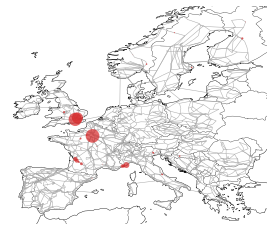

In [4]:
n4_gen_full = pd.read_csv('Output/n4_gen_8760.csv',parse_dates=True,index_col=0)
load_shed = n4_gen_full.loc[:,n4_gen_full.columns.str.contains('EmGenUp1')].sum()
load_shed.index=load_shed.index.str[8:]
n.plot(bus_colors='tab:red',bus_sizes=load_shed/2000000,line_colors='darkgrey',link_colors='darkgrey',
       line_widths=0.5,link_widths=0.5,bus_alpha=0.7)

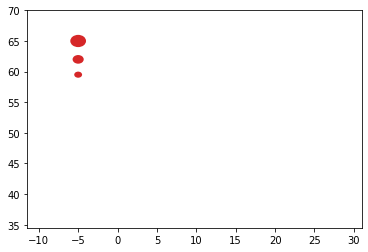

In [5]:
fig, ax = plt.subplots()
circ1 = mpatches.Circle((-5, 65), (2000000/2000000)**0.5, alpha=1, fc='tab:red')
circ2 = mpatches.Circle((-5, 62), (1000000/2000000)**0.5, alpha=1, fc='tab:red')
circ3 = mpatches.Circle((-5, 59.5), (500000/2000000)**0.5, alpha=1, fc='tab:red')
ax.set_xlim(-11.5,31)
ax.set_ylim(34.5,70)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)

In [ ]:
%matplotlib inline

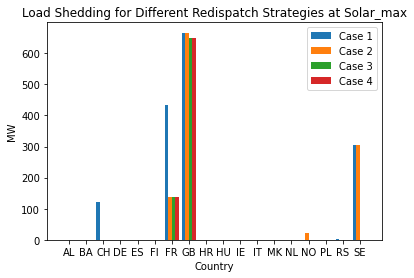

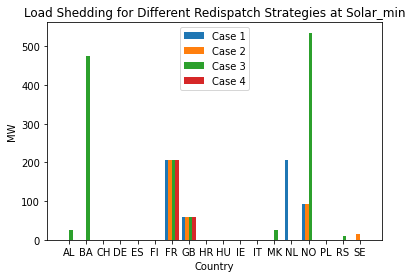

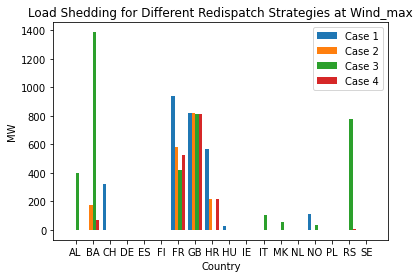

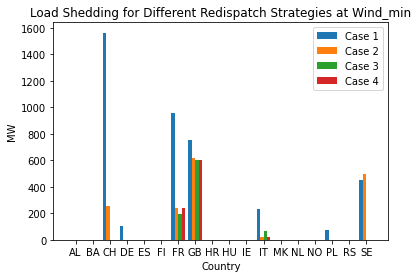

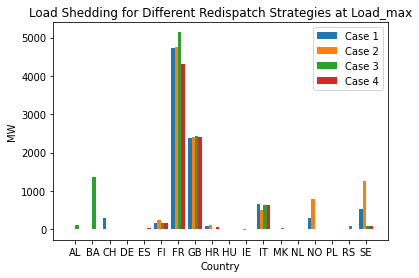

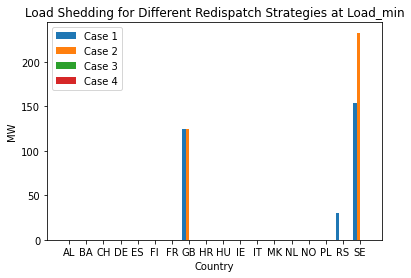

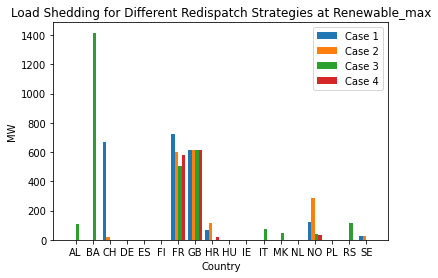

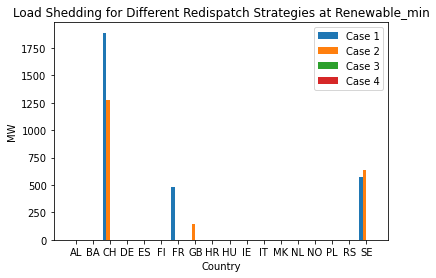

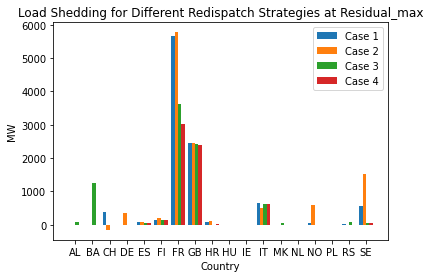

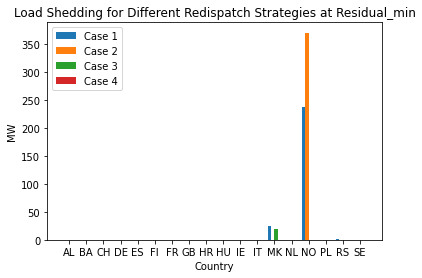

In [6]:
for i in networks:
    if i == 'nz':
        summmm = Generation['nz'][em_gens].groupby(n.generators.loc[em_gens,'country'],axis=1).sum().sum()
    else:
        summmm += Generation[i][em_gens].groupby(n.generators.loc[em_gens,'country'],axis=1).sum().sum()
em_gen_countries = summmm.index[np.where(summmm != 0)]

for j in np.arange(10):
    plt.figure()
    loc = 0
    for i in networks:
        if i != 'nz':
            xvals = np.arange(len(em_gen_countries)) + (0.2*loc - 0.3)
            plt.bar(xvals,Generation[i][em_gens].groupby(n.generators.loc[em_gens,'country'],axis=1).sum().iloc[j].loc[em_gen_countries],label='Case '+str(i[-1:]),width=0.2)
            loc += 1
    plt.xticks(np.arange(len(em_gen_countries)),em_gen_countries)
    plt.legend()      
    plt.ylabel('MW')
    plt.xlabel('Country')
    plt.title('Load Shedding for Different Redispatch Strategies at ' + Index_labels[j])

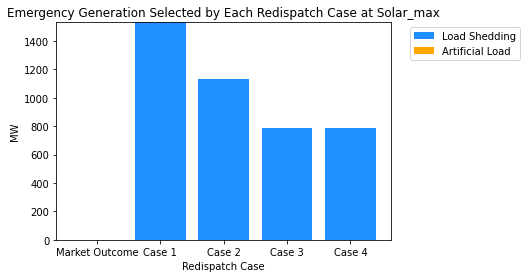

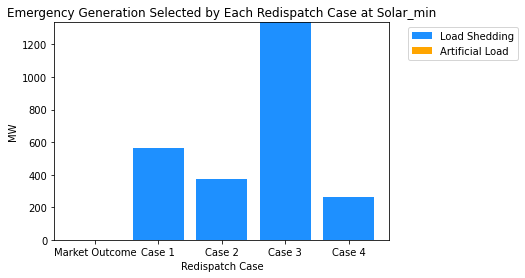

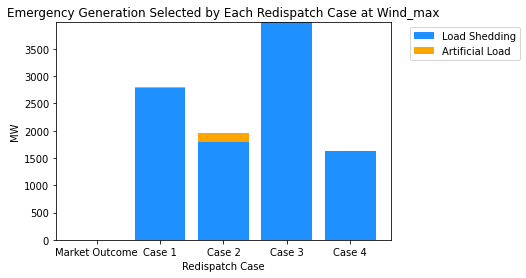

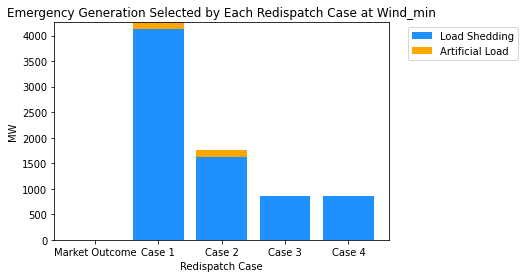

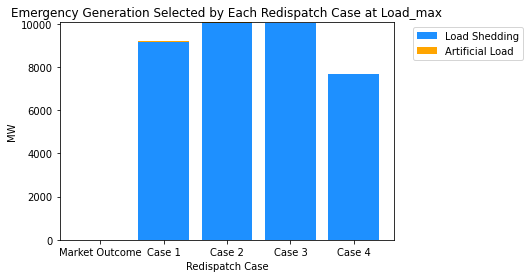

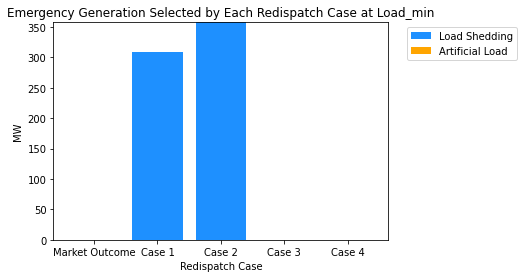

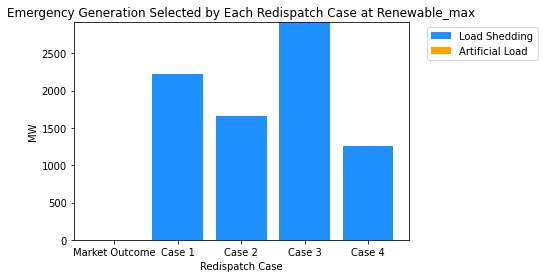

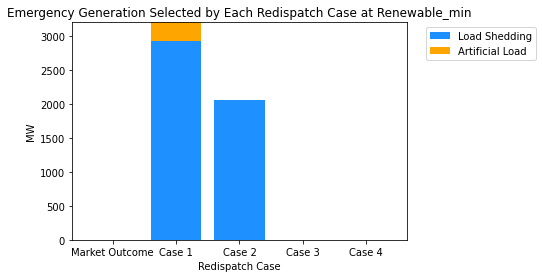

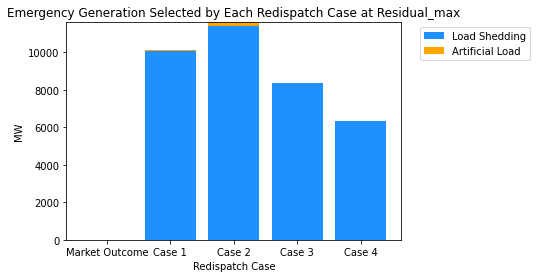

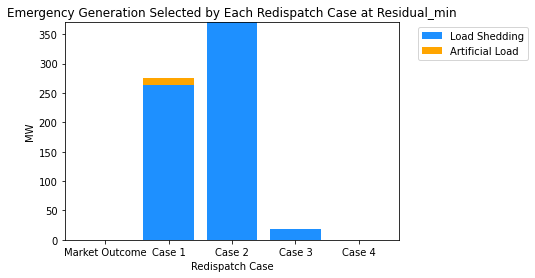

In [7]:
labels = ['Load Shedding','Artificial Load']
colors = ['dodgerblue','orange']
fake_gens = ['EmGenUp1','EmGenDown']

for i in np.arange(10):
    plt.figure()
    summ = np.zeros(5)
    
    for j in np.arange(2):
        gens = n.generators[n.generators.index.str.contains(fake_gens[j])].index
        Data = [Generation[k][gens].iloc[i].sum() for k in networks]
        plt.bar(np.arange(5),Data,label=labels[j],bottom=summ,color=colors[j])   
        summ += Data
            
    plt.xticks(np.arange(5),['Market Outcome','Case 1','Case 2','Case 3','Case 4'])
    plt.legend(bbox_to_anchor=(1.4,1.0))     
    plt.ylabel('MW')
    plt.xlabel('Redispatch Case')
    plt.title('Emergency Generation Selected by Each Redispatch Case at ' + Index_labels[i])

## Congestion

([<matplotlib.axis.XTick at 0x2126a0448c8>,
 [Text(0, 0, 'Jan'),
  Text(0, 0, 'Feb'),
  Text(0, 0, 'Mar'),
  Text(0, 0, 'Apr'),
  Text(0, 0, 'May'),
  Text(0, 0, 'Jun'),
  Text(0, 0, 'Jul'),
  Text(0, 0, 'Aug'),
  Text(0, 0, 'Sep'),
  Text(0, 0, 'Oct'),
  Text(0, 0, 'Nov'),
  Text(0, 0, 'Dec')])

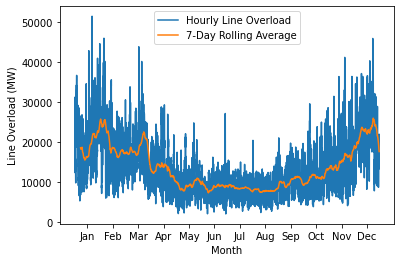

In [8]:
nz_lines_full = pd.read_csv('Output/nz_lines_8760.csv',parse_dates=True,index_col=0)
Lines = nz_lines_full

# Save line limits
S_nom = n.lines.s_nom.copy()

# Fig 2 - market results - number of timesteps with congestion and Where (see fig 2 Kunz)

#Plot total system line overload for every timestep
Line_Overload = pd.DataFrame(index=Lines.index,columns=['Overload (MW)'])
for i in Lines.index:
    Line_Overload.loc[i] = (Lines.loc[i].abs()-S_nom)[Lines.loc[i].abs()-S_nom > 0].sum()

plt.plot(Line_Overload,label='Hourly Line Overload')
plt.plot(Line_Overload.rolling(168).mean(),label = '7-Day Rolling Average')
plt.legend()
plt.ylabel('Line Overload (MW)')
plt.xlabel('Month')
plt.xticks(Line_Overload.index[360::732],[month_abbr[i] for i in np.arange(1,13)])

(0.0, 100.0)

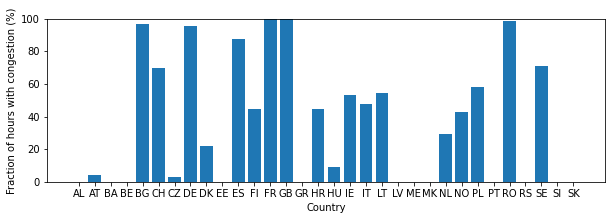

In [10]:
# FIGURE 2
Line_Diff = Lines.abs()-S_nom
Line_Diff[Line_Diff < 0] = 0

plt.figure(figsize=(10, 3))
plt.bar(np.sort(n.buses.country.unique()),(((Line_Diff > 0).groupby(np.array(n.buses.loc[n.lines.loc[Line_Diff.columns,'bus0'],'country']),axis=1).sum())>0).sum()/87.6)
plt.ylabel('Fraction of hours with congestion (%)')
plt.xlabel('Country')
plt.ylim(0,100)

(<matplotlib.collections.PatchCollection at 0x2120e6099c8>,
 <matplotlib.collections.LineCollection at 0x2120e0e0308>)

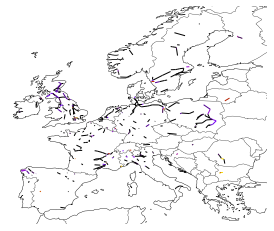

In [11]:
num_congestions = (Line_Diff > 0).sum()

n.plot(line_widths=(num_congestions>0),link_widths=0,bus_colors='black',link_colors=0,line_colors=(num_congestions/438).apply(np.floor),bus_sizes=0,line_cmap='gnuplot')

Text(0, 0.5, 'Load (MW)')

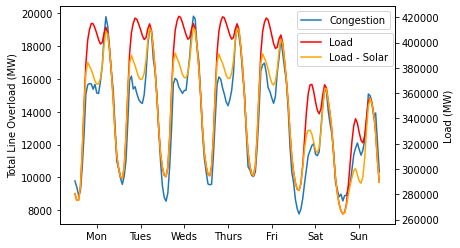

In [12]:
Load = n.loads_t.p_set.sum(axis=1)
Load = [float(Load.iloc[i::168].mean()) for i in np.arange(168)]
Week_Average = [float(Line_Overload.iloc[i::168].mean()) for i in np.arange(168)]
Solar_p = (n.generators_t.p_max_pu.loc[:,n.generators_t.p_max_pu.columns.str.contains('solar')]*n.generators[n.generators.carrier == 'solar'].p_nom).sum(axis=1)
Solar_ave = [float(Solar_p.iloc[i::168].mean()) for i in np.arange(168)]

fig, ax1 = plt.subplots()

ax1.plot(np.roll(Week_Average,24),label='Congestion')
ax1.set_xticks(np.arange(12,180,24))
ax1.set_xticklabels(['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'])
ax2 = ax1.twinx()
ax2.plot(np.roll(Load,24),color='red',label='Load')
ax2.plot(np.roll(np.array(Load)-np.array(Solar_ave),24),color='orange',label='Load - Solar')
ax1.legend()
ax2.legend(loc=1,bbox_to_anchor=(1.009,0.9))
ax1.set_ylabel('Total Line Overload (MW)')
ax2.set_ylabel('Load (MW)')

In [13]:
r1 = stats.pearsonr(np.array(Load)-np.array(Solar_ave),Week_Average)
r2 = stats.pearsonr(np.array(Load),Week_Average)
print(r1[0],r2[0])

0.963736862803432 0.9062644866055668


Text(0, 0.5, 'Line Overload (MW)')

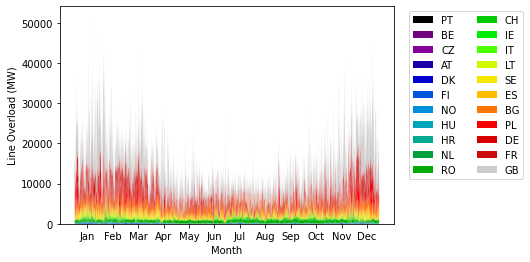

In [14]:
Country_Overflow = Line_Diff.groupby(np.array(n.buses.loc[n.lines.loc[Line_Diff.columns,'bus0'],'country']),axis=1).sum().T
Country_Overflow = Country_Overflow.loc[Country_Overflow.T.sum()>0]
Country_Overflow = Country_Overflow.loc[Country_Overflow.std(axis=1).sort_values().index]
#Country_Overflow = Country_Overflow.loc[Country_Overflow.std(axis=1).sort_values()>160]
colors = [plt.cm.nipy_spectral(i) for i in np.linspace(0, 1,len(Country_Overflow.index))]

plt.stackplot(Lines.index,Country_Overflow,labels=Country_Overflow.index,colors=colors)
plt.legend(ncol=2,bbox_to_anchor=(1.4,1.0))
plt.xlabel('Month')
plt.xticks(Line_Overload.index[360::732],[month_abbr[i] for i in np.arange(1,13)])
plt.ylabel('Line Overload (MW)')

Text(0, 0.5, 'Average Line Overload (MW)')

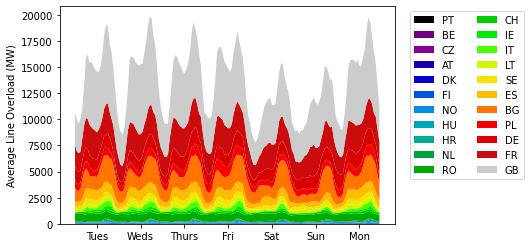

In [15]:
Week_Overflow = pd.DataFrame(index=Country_Overflow.index)
for i in np.arange(168):
    Week_Overflow[i] = Country_Overflow.iloc[:,i::168].mean(axis=1)
    
plt.stackplot(np.arange(168),Week_Overflow,labels=Week_Overflow.index,colors=colors)
plt.legend(ncol=2,bbox_to_anchor=(1.4,1.0))
plt.xticks(np.arange(12,180,24),['Tues','Weds','Thurs','Fri','Sat','Sun','Mon'])
plt.ylabel('Average Line Overload (MW)')

## Redispatch Costs

In [17]:
Kunz_countries = ['DE','PL','SK','AT','CZ']

VoLL_country = {'PT':5890,'NL':22940,'IT':11340,'ES':7880,'IE':11520,'HU':3270,'GR':4240,'FR':6920,'AL':5000,'MK':5000,
                'CH':5000,'RO':4520,'BG':1500,'RS':5000,'BA':5000,'ME':5000,'HR':3150,'BE':9600,'AT':9010,'SK':4730,
                'CZ':3530,'DE':12410,'SI':4320,'PL':6260,'GB':15900,'LT':4620,'DK':15730,'SE':5520,'EE':5180,'LV':4710,
                'NO':5000,'FI':5300}

for i in n.buses.country.unique():
    n.generators.loc[n.generators.loc[em_gens][n.generators.loc[em_gens].country == i].index,'marginal_cost'] = VoLL_country[i]
    
n.generators.loc[n.generators.index.str.contains('EmGenDown'),'marginal_cost'] = -1*n.generators.loc[n.generators.index.str.contains('EmGenDown'),'marginal_cost']

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [63]:
nz_costs_real = Generation['nz'][real_gens]*n.generators.marginal_cost.loc[real_gens]
n1_costs_real = Generation['n1'][real_gens]*n.generators.marginal_cost.loc[real_gens]-nz_costs_real
n2_costs_real = Generation['n2'][real_gens]*n.generators.marginal_cost.loc[real_gens]-nz_costs_real
n3_costs_real = Generation['n3'][real_gens]*n.generators.marginal_cost.loc[real_gens]-nz_costs_real
n4_costs_real = Generation['n4'][real_gens]*n.generators.marginal_cost.loc[real_gens]-nz_costs_real
n1_costs_real[RE_gens]=n1_costs_real[RE_gens].clip(lower=0)
n2_costs_real[RE_gens]=n2_costs_real[RE_gens].clip(lower=0)
n3_costs_real[RE_gens]=n3_costs_real[RE_gens].clip(lower=0)
n4_costs_real[RE_gens]=n4_costs_real[RE_gens].clip(lower=0)
Costs_real = [n1_costs_real,n2_costs_real,n3_costs_real,n4_costs_real]
Costs_real = [i.groupby(n.generators.country,axis=1).sum() for i in Costs_real]

nz_costs = Generation['nz']*n.generators.marginal_cost
n1_costs = Generation['n1']*n.generators.marginal_cost-nz_costs
n2_costs = Generation['n2']*n.generators.marginal_cost-nz_costs
n3_costs = Generation['n3']*n.generators.marginal_cost-nz_costs
n4_costs = Generation['n4']*n.generators.marginal_cost-nz_costs
n1_costs[RE_gens]=n1_costs[RE_gens].clip(lower=0)
n2_costs[RE_gens]=n2_costs[RE_gens].clip(lower=0)
n3_costs[RE_gens]=n3_costs[RE_gens].clip(lower=0)
n4_costs[RE_gens]=n4_costs[RE_gens].clip(lower=0)
Costs = [n1_costs,n2_costs,n3_costs,n4_costs]
Costs = [i.groupby(n.generators.country,axis=1).sum() for i in Costs]

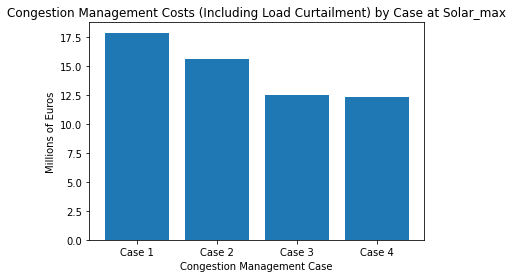

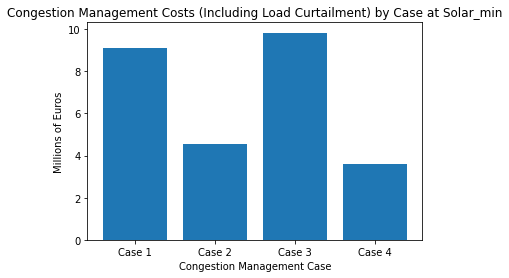

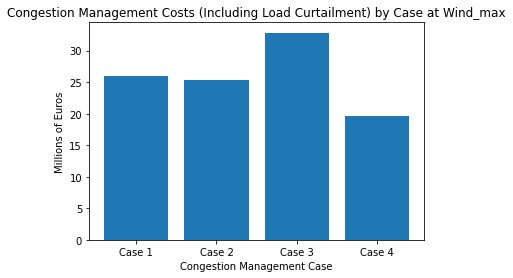

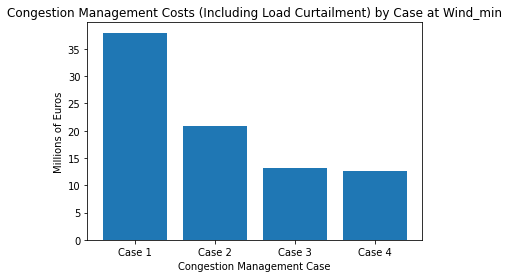

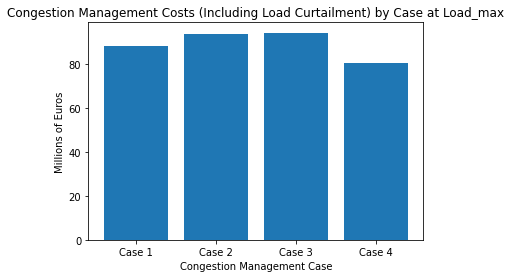

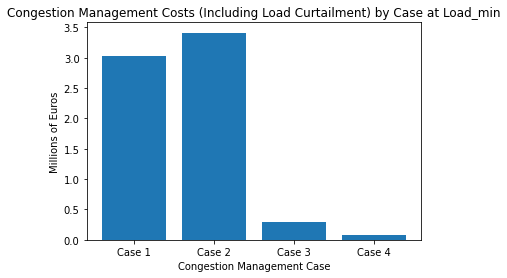

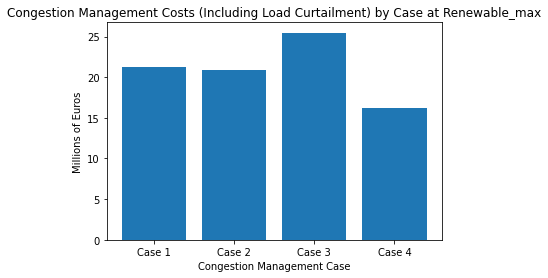

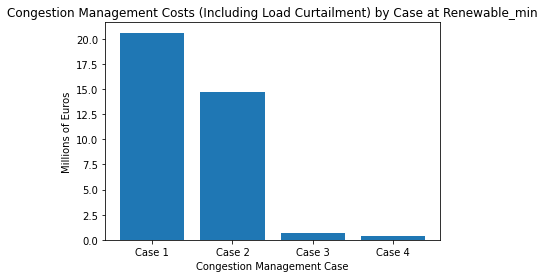

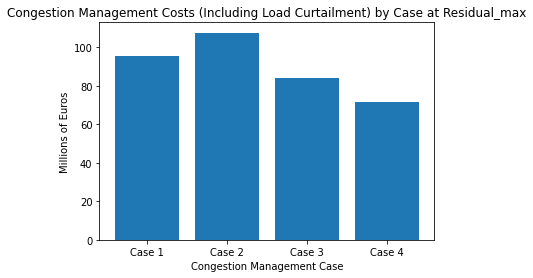

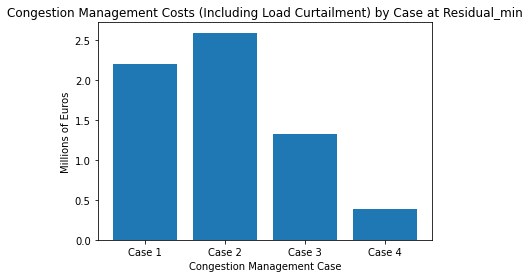

In [128]:
for j in np.arange(10):
    plt.figure()
    xvals = np.arange(4)
    plt.bar(xvals,[Costs[i].iloc[j].clip(lower=0).sum()/1000000 for i in np.arange(4)])
    plt.xticks(np.arange(4),['Case 1','Case 2','Case 3','Case 4']) 
    plt.ylabel('Millions of Euros')
    plt.xlabel('Congestion Management Case')
    plt.title('Congestion Management Costs (Including Load Curtailment) by Case at ' + Index_labels[j])

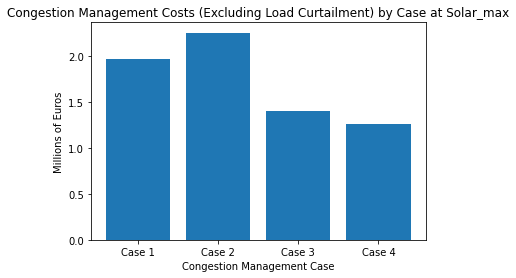

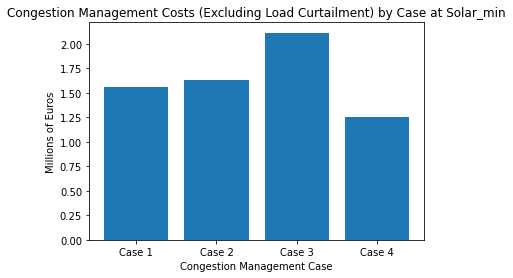

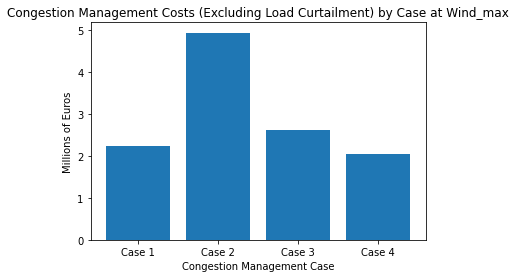

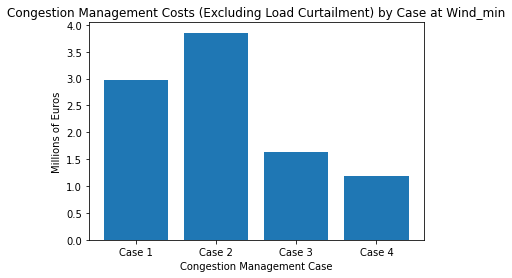

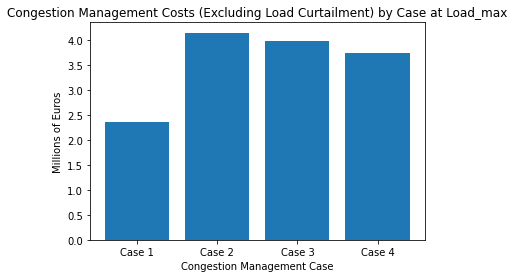

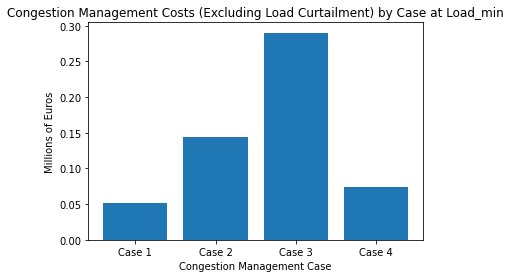

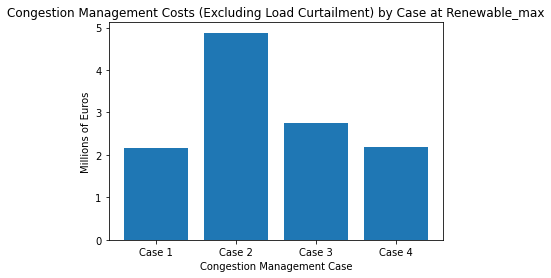

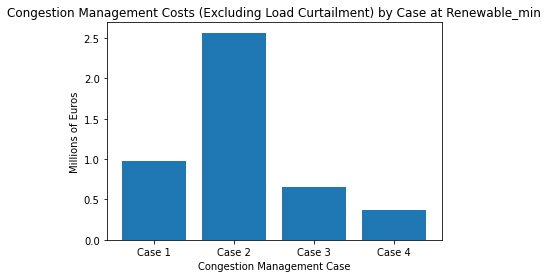

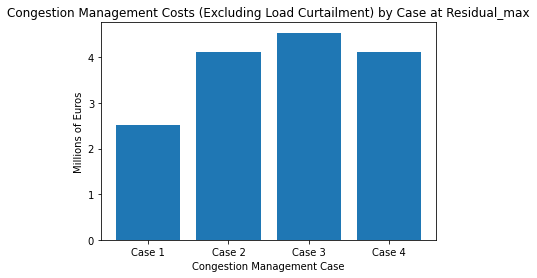

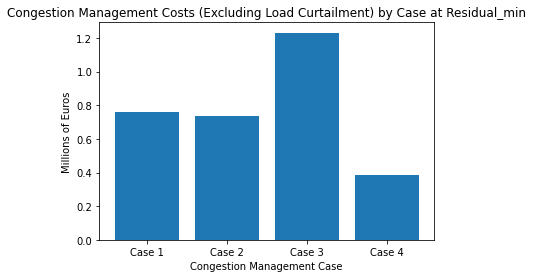

In [129]:
for j in np.arange(10):
    plt.figure()
    xvals = np.arange(4)
    plt.bar(xvals,[Costs_real[i].iloc[j].clip(lower=0).sum()/1000000 for i in np.arange(4)])
    plt.xticks(np.arange(4),['Case 1','Case 2','Case 3','Case 4']) 
    plt.ylabel('Millions of Euros')
    plt.xlabel('Congestion Management Case')
    plt.title('Congestion Management Costs (Excluding Load Curtailment) by Case at ' + Index_labels[j])

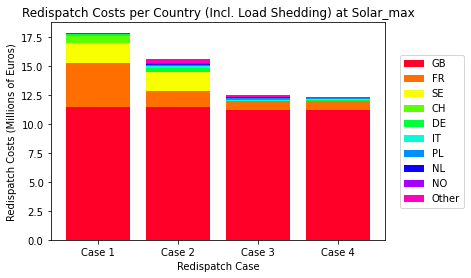

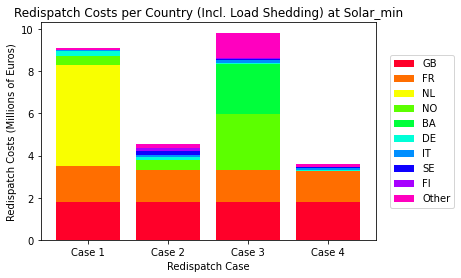

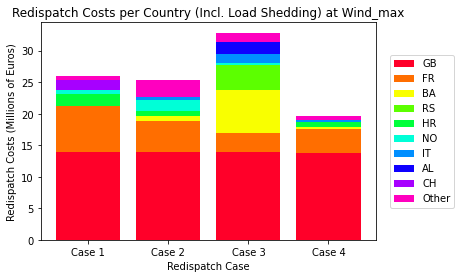

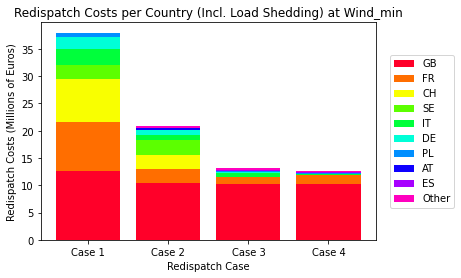

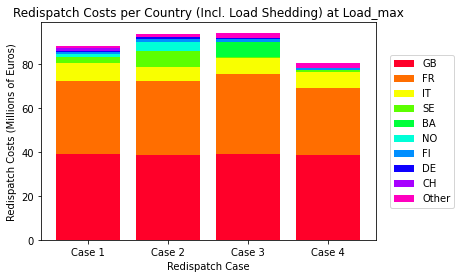

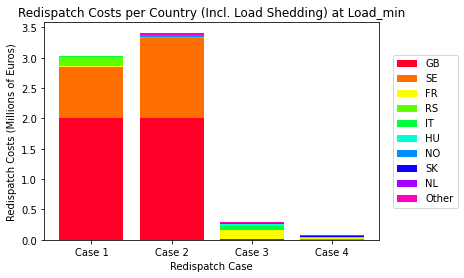

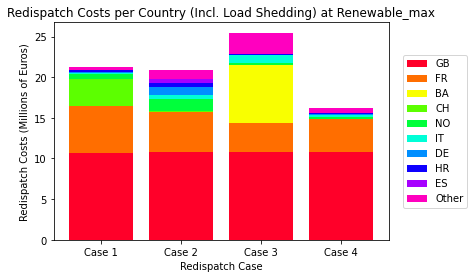

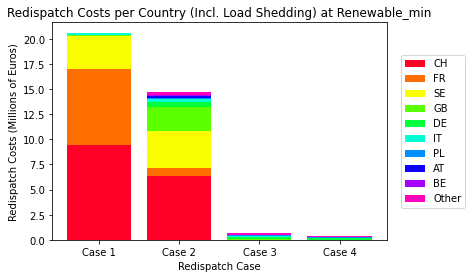

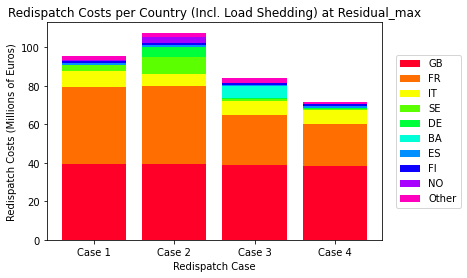

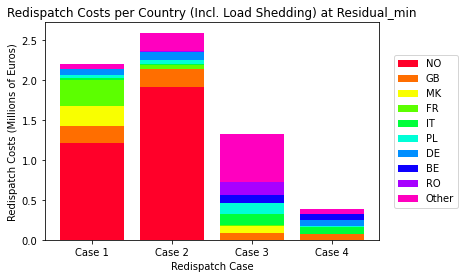

In [126]:
for i in np.arange(10):
    plt.figure()
    summ = np.zeros(4)
    RD_countries = sum(Costs).iloc[i].sort_values(ascending=False).iloc[:9].index
    other_countries = sum(Costs).iloc[i].sort_values(ascending=False).iloc[9:].index
    colors = [plt.cm.gist_rainbow(i) for i in np.linspace(0, 1,len(RD_countries)+1)]
    
    for j in np.arange(len(RD_countries)):
        Data = [Costs[k].clip(lower=0)[RD_countries[j]].iloc[i]/1000000 for k in np.arange(4)]
        plt.bar(np.arange(4),Data,label=RD_countries[j],bottom=summ,color=colors[j])   
        summ += Data           
            
    Data = [Costs[k].clip(lower=0)[other_countries].iloc[i].sum()/1000000 for k in np.arange(4)]
    plt.bar(np.arange(4),Data,label='Other',bottom=summ,color=colors[-1])   
    
    plt.xticks(np.arange(4),['Case 1','Case 2','Case 3','Case 4'])
    plt.legend(loc=7,bbox_to_anchor=(1.25,0.5))     
    plt.ylabel('Redispatch Costs (Millions of Euros)')
    plt.xlabel('Redispatch Case')
    plt.title('Redispatch Costs per Country (Incl. Load Shedding) at ' + Index_labels[i])

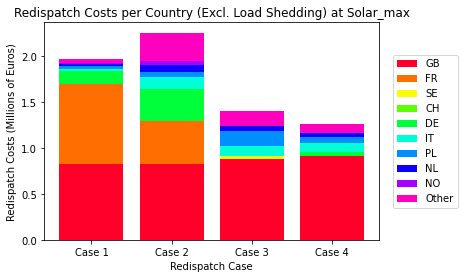

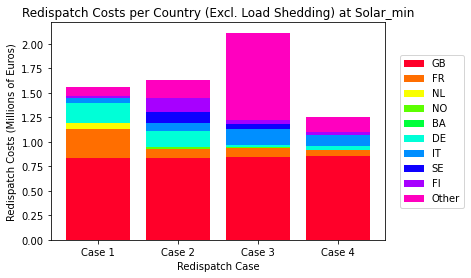

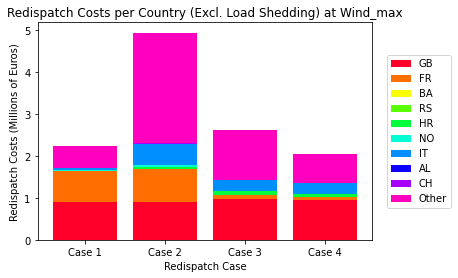

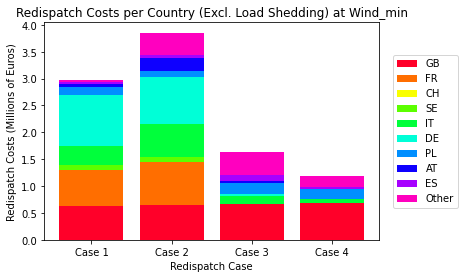

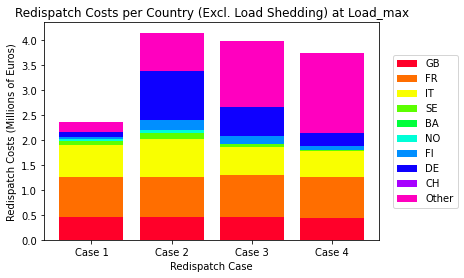

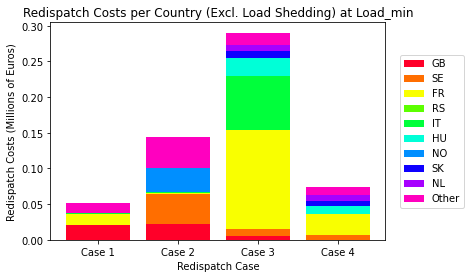

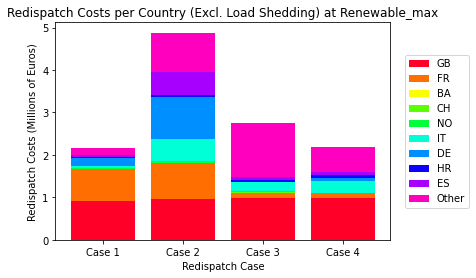

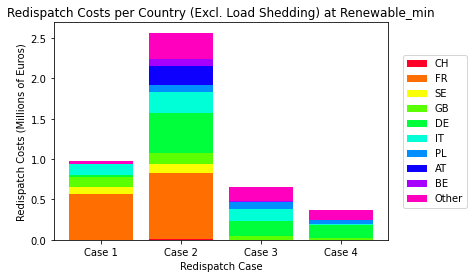

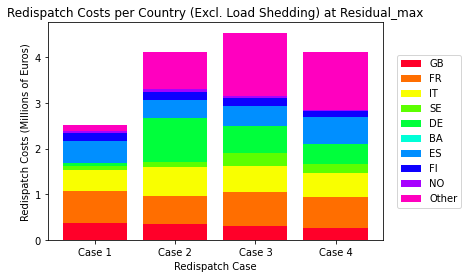

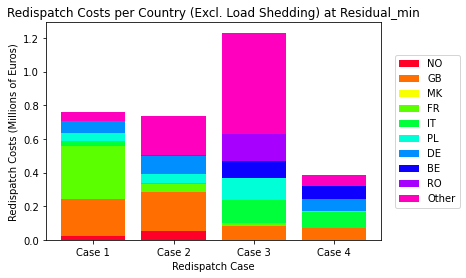

In [127]:
for i in np.arange(10):
    plt.figure()
    summ = np.zeros(4)
    RD_countries = sum(Costs).iloc[i].sort_values(ascending=False).iloc[:9].index
    other_countries = sum(Costs).iloc[i].sort_values(ascending=False).iloc[9:].index
    colors = [plt.cm.gist_rainbow(i) for i in np.linspace(0, 1,len(RD_countries)+1)]
    
    for j in np.arange(len(RD_countries)):
        Data = [Costs_real[k].clip(lower=0)[RD_countries[j]].iloc[i]/1000000 for k in np.arange(4)]
        plt.bar(np.arange(4),Data,label=RD_countries[j],bottom=summ,color=colors[j])   
        summ += Data
        
    Data = [Costs_real[k].clip(lower=0)[other_countries].iloc[i].sum()/1000000 for k in np.arange(4)]
    plt.bar(np.arange(4),Data,label='Other',bottom=summ,color=colors[-1])   
    
    plt.xticks(np.arange(4),['Case 1','Case 2','Case 3','Case 4'])
    plt.legend(loc=7,bbox_to_anchor=(1.25,0.5))     
    plt.ylabel('Redispatch Costs (Millions of Euros)')
    plt.xlabel('Redispatch Case')
    plt.title('Redispatch Costs per Country (Excl. Load Shedding) at ' + Index_labels[i])
#plt.pie(n1_costs.iloc[1].sort_values(),labels=n1_costs.iloc[1].sort_values().index)

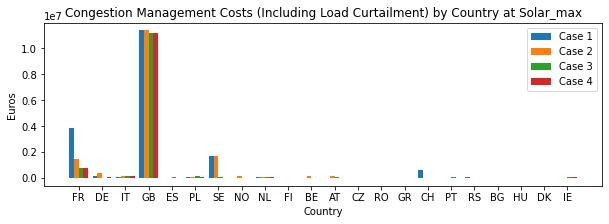

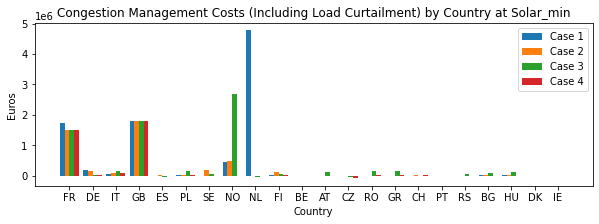

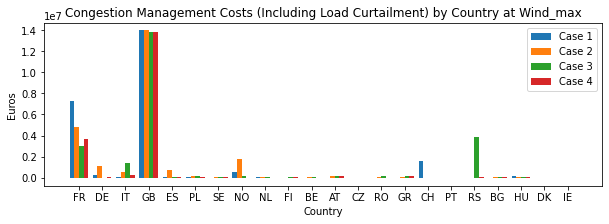

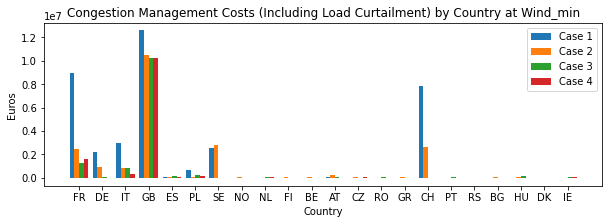

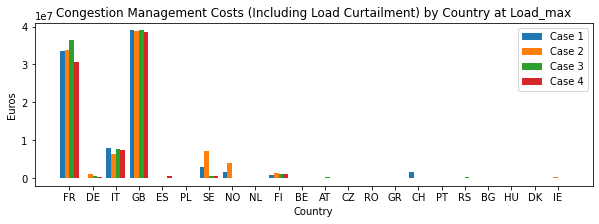

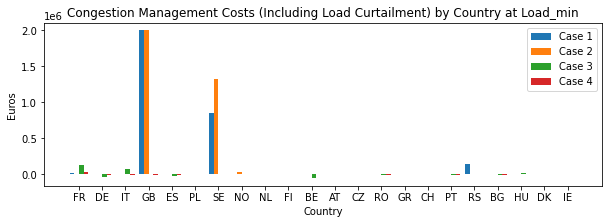

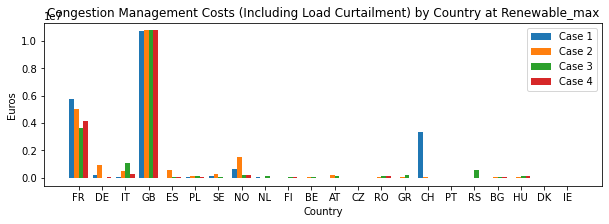

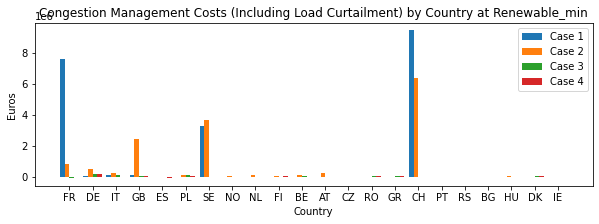

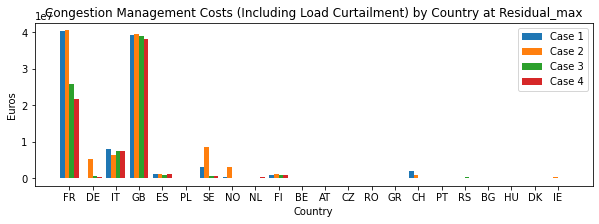

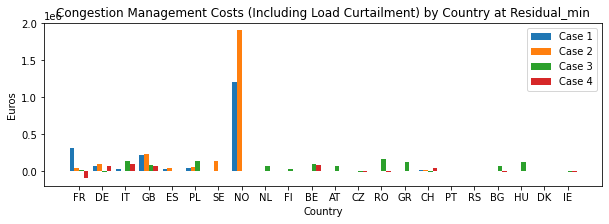

In [86]:
# Table 3

for j in np.arange(10):
    plt.figure(figsize=(10, 3))
    loc = 0
    for i in np.arange(4):
        xvals = np.arange(len(Top_22)) + (0.2*loc - 0.3)
        plt.bar(xvals,Costs[i].iloc[j].loc[Top_22],label='Case '+str(i+1),width=0.2)
        loc += 1
    plt.xticks(np.arange(len(Top_22)),Top_22)
    plt.legend()      
    plt.ylabel('Euros')
    plt.xlabel('Country')
    plt.title('Congestion Management Costs (Including Load Curtailment) by Country at ' + Index_labels[j])

## Redispatch Volumes

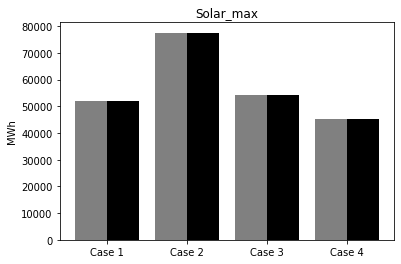

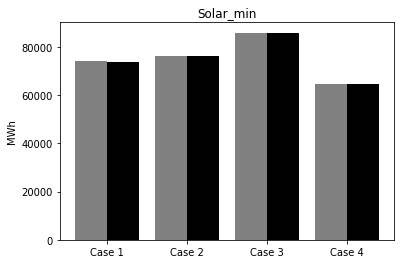

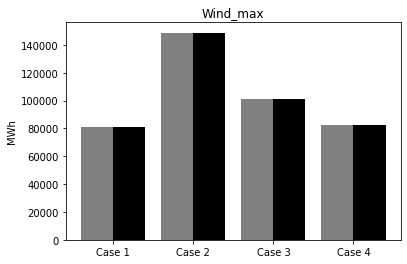

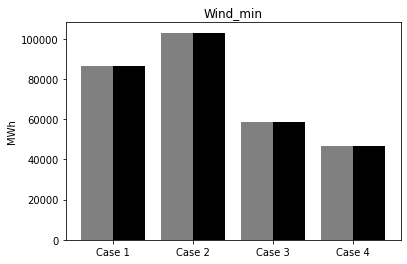

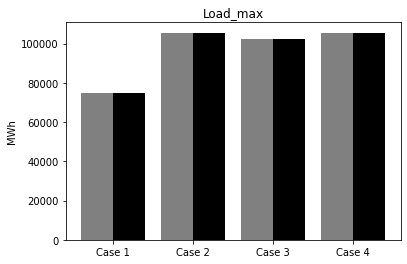

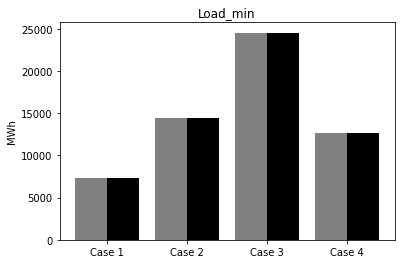

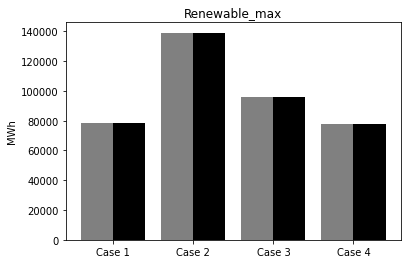

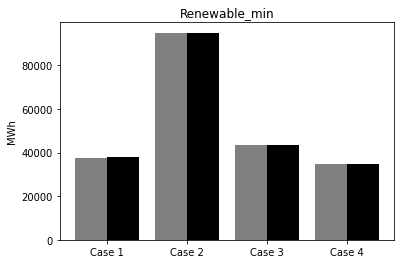

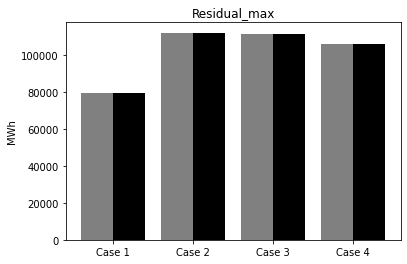

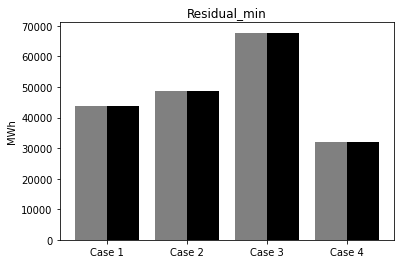

In [22]:
RD_up = {}
RD_down = {}
RD_up_s = {}
RD_down_s = {}

for i in networks:
    if i != 'nz':
        RD_up[i] = (Generation[i]-Generation['nz'])
        RD_up[i][RD_up[i] < 0] = 0
        RD_down[i] = (Generation['nz']-Generation[i])
        RD_down[i][RD_down[i] < 0] = 0
        RD_up_s[i] = (Storage[i]-Storage['nz'])
        RD_up_s[i][RD_up_s[i] < 0] = 0
        RD_down_s[i] = (Storage['nz']-Storage[i])
        RD_down_s[i][RD_down_s[i] < 0] = 0        

for j in np.arange(10):
    plt.figure()
    xvals = np.arange(4) -0.2
    vals = [RD_up[i].iloc[j].sum() + RD_up_s[i].iloc[j].sum() for i in networks[1:]]
    plt.bar(xvals,vals,label='Positive Redispatch',width=0.4,color='gray')
    
    xvals = np.arange(4) +0.2
    vals = [RD_down[i].iloc[j].sum() + RD_down_s[i].iloc[j].sum() for i in networks[1:]]
    plt.bar(xvals,vals,label='Negative Redispatch',width=0.4,color='black')
    plt.xticks(np.arange(4),['Case 1','Case 2','Case 3','Case 4'])
    
    #plt.legend()      
    plt.ylabel('MWh')
    #plt.xlabel('Redispatch Case')
    plt.title(Index_labels[j]) #'Redispatch Volumes Across the Four Coordination Cases at ' + 

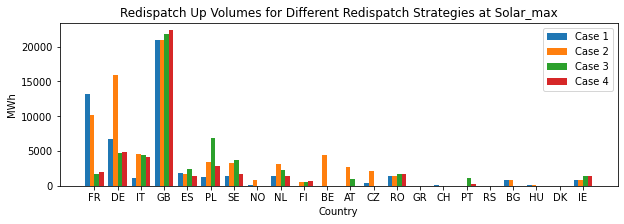

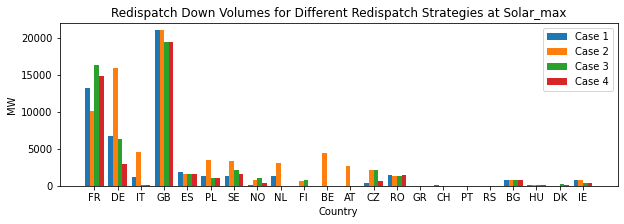

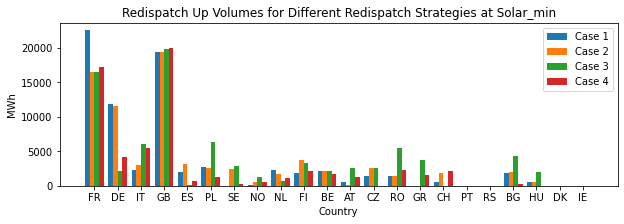

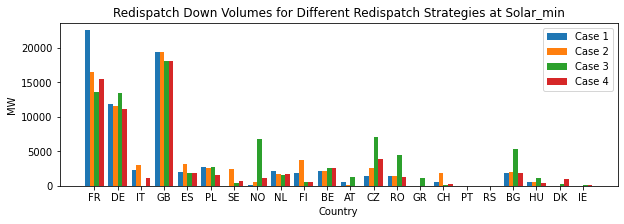

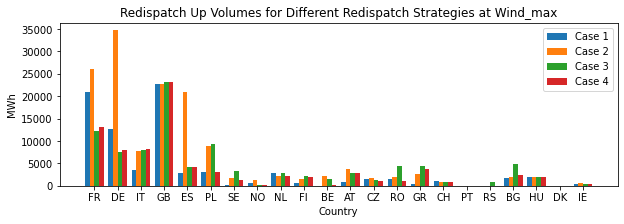

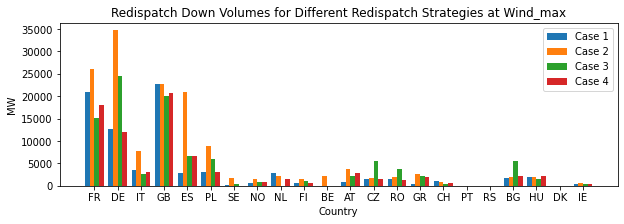

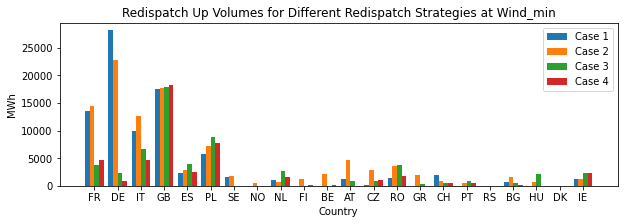

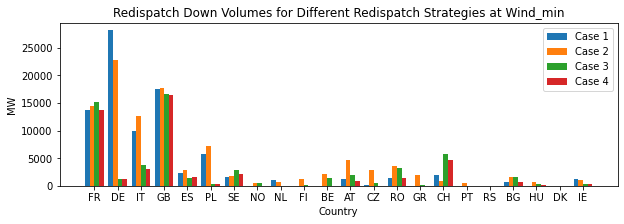

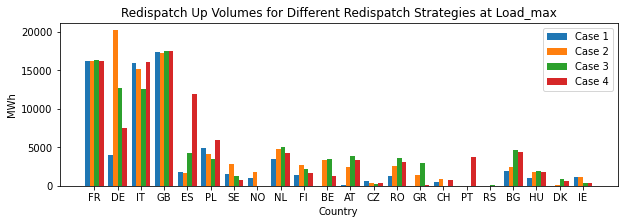

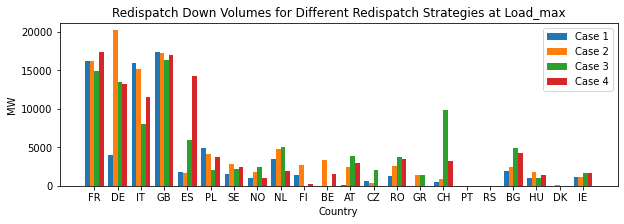

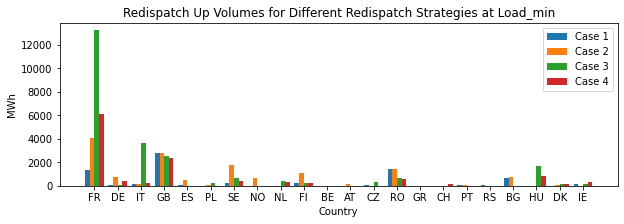

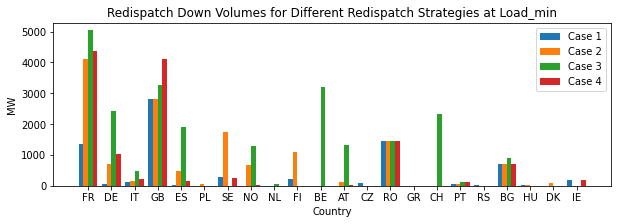

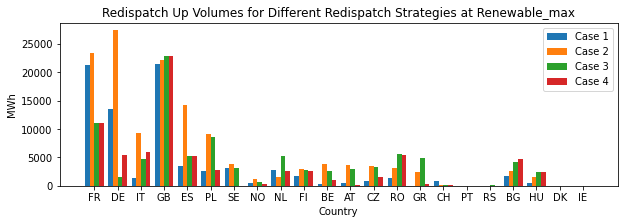

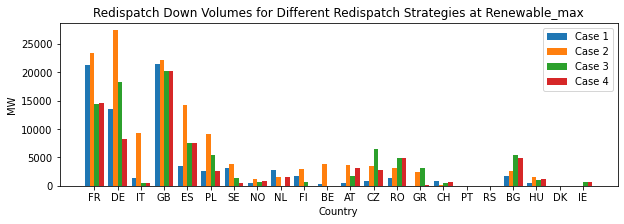

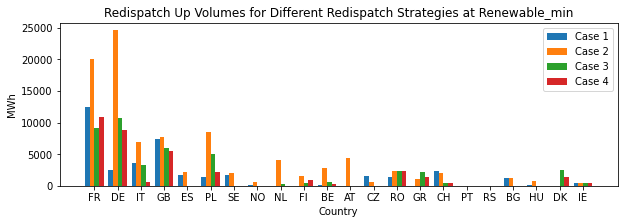

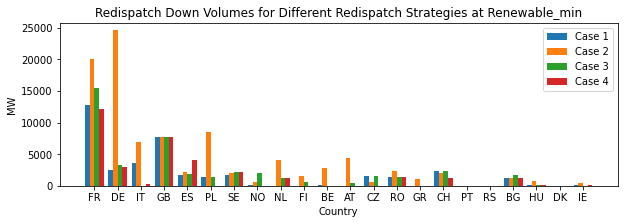

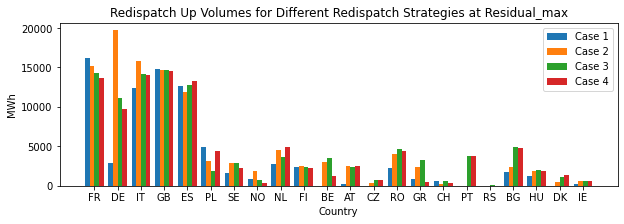

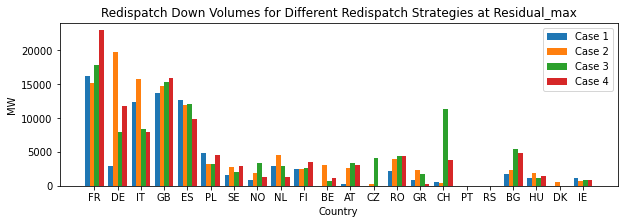

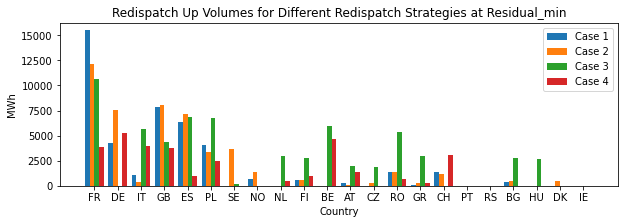

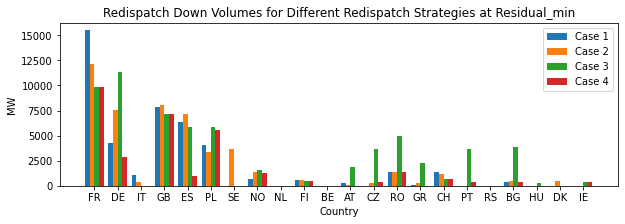

In [23]:
for j in np.arange(10):
    plt.figure(figsize=(10, 3))
    loc = 0
    for i in networks:
        if i != 'nz':
            Country_RD = RD_up[i].groupby(n.generators.country,axis=1).sum().iloc[j].add(RD_up_s[i].groupby(n.storage_units.country,axis=1).sum().iloc[j],fill_value=0)
            xvals = np.arange(len(Top_22)) + (0.2*loc - 0.3)
            plt.bar(xvals,Country_RD.loc[Top_22],label='Case '+i[-1:],width=0.2)
            loc += 1
    plt.xticks(np.arange(len(Top_22)),Top_22)
    plt.legend()      
    plt.ylabel('MWh')
    plt.xlabel('Country')
    plt.title('Redispatch Up Volumes for Different Redispatch Strategies at ' + Index_labels[j])

    plt.figure(figsize=(10, 3))
    loc = 0
    for i in networks:
        if i != 'nz':
            Country_RD = RD_down[i].groupby(n.generators.country,axis=1).sum().iloc[j].add(RD_down_s[i].groupby(n.storage_units.country,axis=1).sum().iloc[j],fill_value=0)
            xvals = np.arange(len(Top_22)) + (0.2*loc - 0.3)
            plt.bar(xvals,Country_RD.loc[Top_22],label='Case '+i[-1:],width=0.2)
            loc += 1
    plt.xticks(np.arange(len(Top_22)),Top_22)
    plt.legend()      
    plt.ylabel('MW')
    plt.xlabel('Country')
    plt.title('Redispatch Down Volumes for Different Redispatch Strategies at ' + Index_labels[j])

## Generation Types

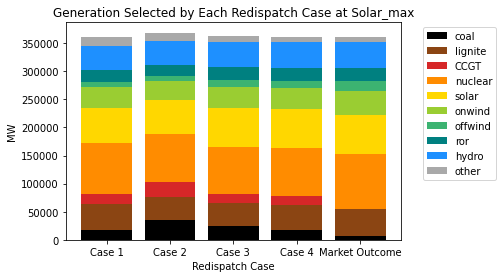

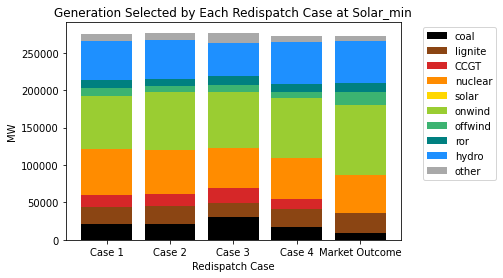

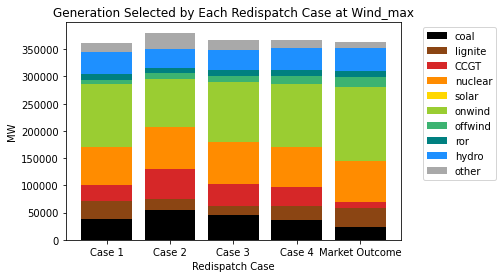

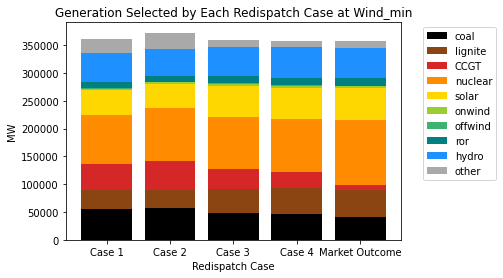

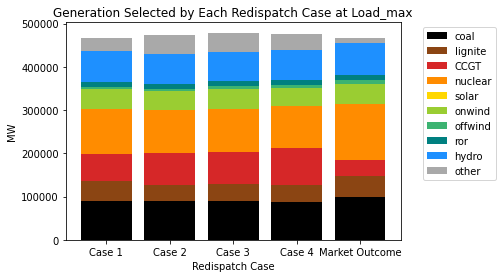

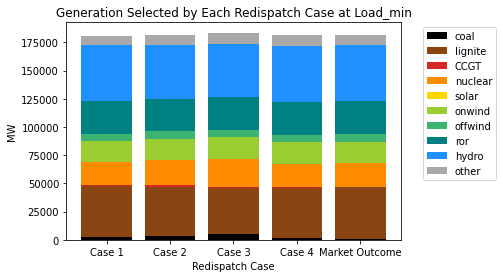

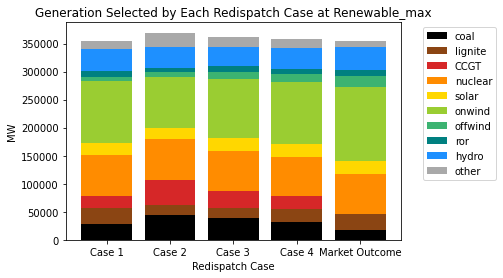

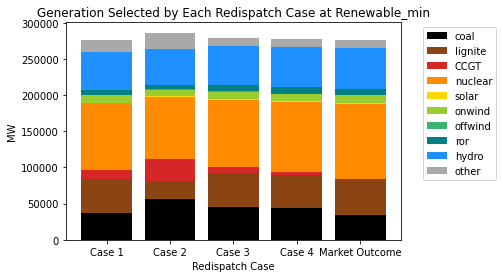

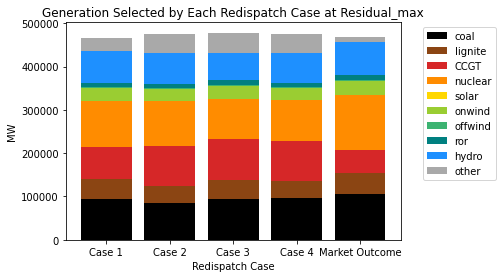

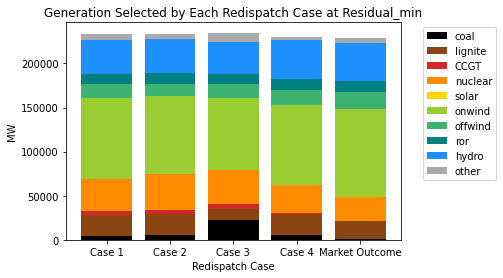

In [119]:
carriers = ['coal','lignite','CCGT','nuclear','solar','onwind','offwind','ror','hydro','other']
colors = ['black','saddlebrown','tab:red','darkorange','gold','yellowgreen','mediumseagreen','teal','dodgerblue','darkgray']

for i in np.arange(10):
    plt.figure()
    summ = np.zeros(5)
    
    for j in np.arange(len(carriers)):
        if carriers[j] == 'hydro':
            gens = n.storage_units[n.storage_units.carrier.str.contains('hydro')].index
            Data = [Storage[k][gens].iloc[i].sum() for k in np.roll(networks,-1)]
            plt.bar(np.arange(5),Data,label=carriers[j],bottom=summ,color=colors[j])   
            summ += Data
        elif carriers[j] == 'other':
            gens = n.generators[n.generators.carrier.str.contains('biomass|geothermal|oil|OCGT')].index
            Data = [Generation[k][gens].iloc[i].sum() for k in np.roll(networks,-1)]
            plt.bar(np.arange(5),Data,label=carriers[j],bottom=summ,color=colors[j])        
        else:
            gens = n.generators[n.generators.carrier.str.contains(carriers[j])].index
            Data = [Generation[k][gens].iloc[i].sum() for k in np.roll(networks,-1)]
            plt.bar(np.arange(5),Data,label=carriers[j],bottom=summ,color=colors[j])    
            summ += Data
            
    plt.xticks(np.arange(5),['Case 1','Case 2','Case 3','Case 4','Market Outcome'])
    plt.legend(bbox_to_anchor=(1.3,1.0))     
    plt.ylabel('MW')
    plt.xlabel('Redispatch Case')
    plt.title('Generation Selected by Each Redispatch Case at ' + Index_labels[i])

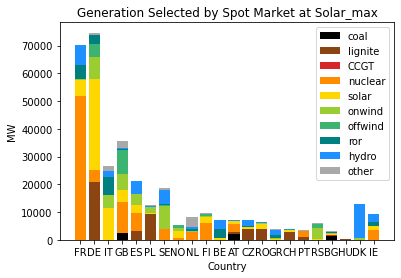

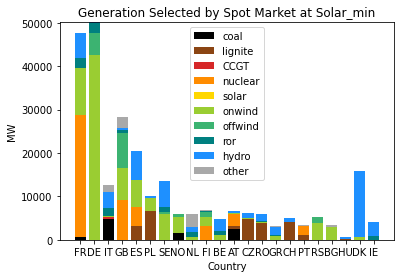

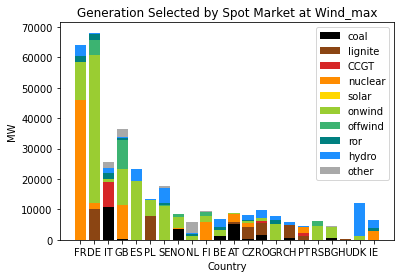

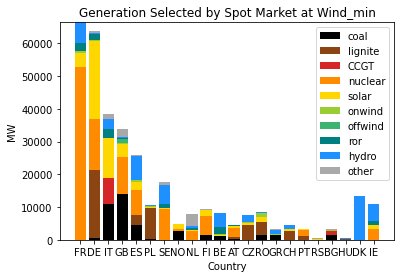

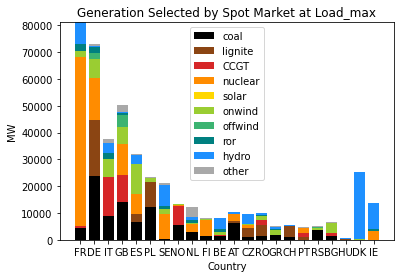

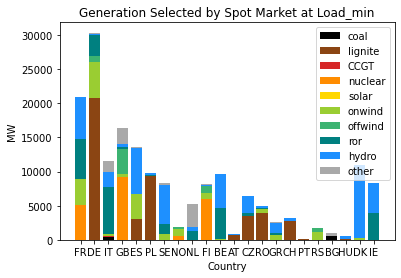

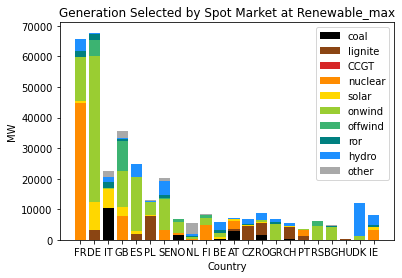

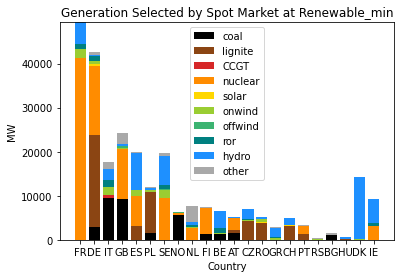

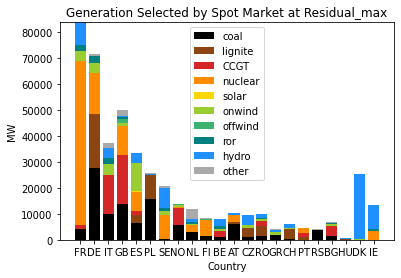

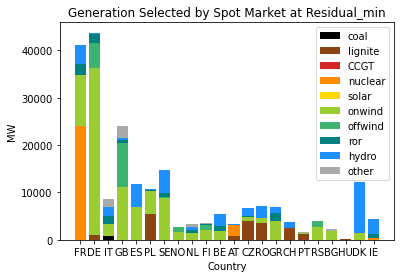

In [25]:
carriers = ['coal','lignite','CCGT','nuclear','solar','onwind','offwind','ror','hydro','other']
colors = ['black','saddlebrown','tab:red','darkorange','gold','yellowgreen','mediumseagreen','teal','dodgerblue','darkgray']

for i in np.arange(10):
    plt.figure()
    summ = pd.Series(index=Top_22,data=0)
    
    for j in np.arange(len(carriers)):
        if carriers[j] == 'hydro':
            gens = n.storage_units[n.storage_units.carrier.str.contains('hydro')].index
            Countries = Top_22[[(i in list(set(n.storage_units.country.unique()) & set(Top_22))) for i in Top_22]]
            plt.bar(Countries,Storage['nz'][gens].groupby(n.storage_units.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],
                    label=carriers[j],bottom=summ[Countries],color=colors[j])   
            summ = summ.add(Storage['nz'][gens].groupby(n.storage_units.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],fill_value=0)
        elif carriers[j] == 'other':
            gens = n.generators[n.generators.carrier.str.contains('biomass|geothermal|oil|OCGT')].index
            Countries = Top_22[[(i in list(set(n.generators.loc[gens].country.unique()) & set(Top_22))) for i in Top_22]]
            plt.bar(Countries,Generation['nz'][gens].groupby(n.generators.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],
                    label=carriers[j],bottom=summ[Countries],color=colors[j])        
        else:
            gens = n.generators[n.generators.carrier.str.contains(carriers[j])].index
            Countries = Top_22[[(i in list(set(n.generators.loc[gens].country.unique()) & set(Top_22))) for i in Top_22]]
            plt.bar(Countries,Generation['nz'][gens].groupby(n.generators.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],
                    label=carriers[j],bottom=summ[Countries],color=colors[j])
            summ = summ.add(Generation['nz'][gens].groupby(n.generators.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],fill_value=0)

    plt.xticks(np.arange(len(Top_22)),Top_22)
    plt.legend()      
    plt.ylabel('MW')
    plt.xlabel('Country')
    plt.title('Generation Selected by Spot Market at ' + Index_labels[i])

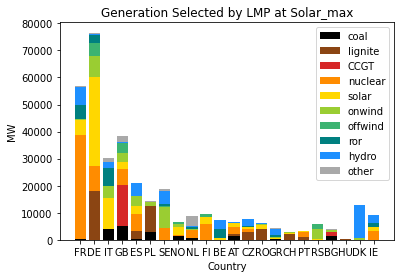

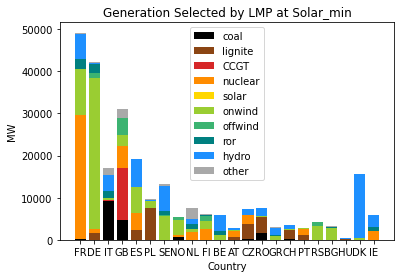

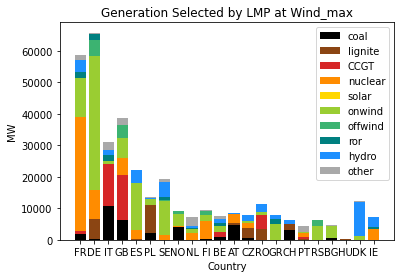

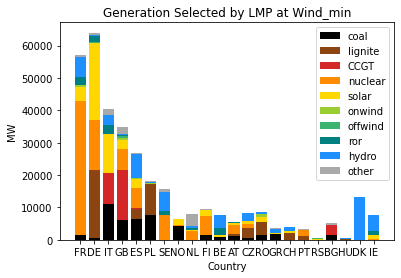

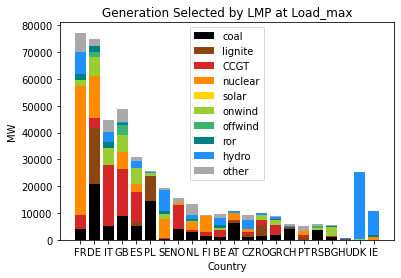

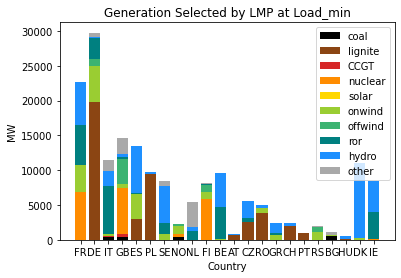

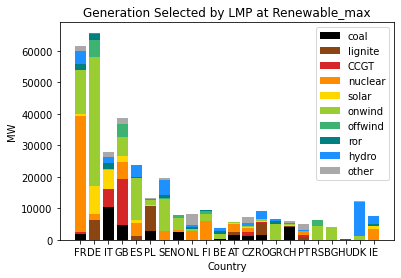

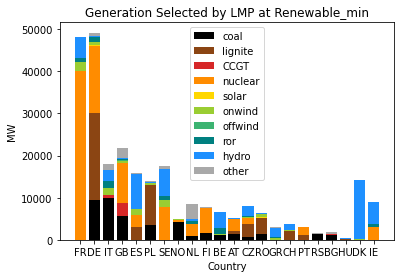

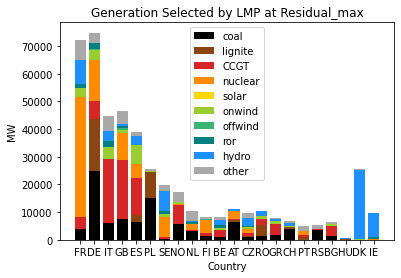

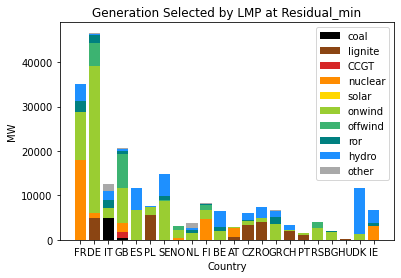

In [26]:
carriers = ['coal','lignite','CCGT','nuclear','solar','onwind','offwind','ror','hydro','other']
colors = ['black','saddlebrown','tab:red','darkorange','gold','yellowgreen','mediumseagreen','teal','dodgerblue','darkgray']

for i in np.arange(10):
    plt.figure()
    summ = pd.Series(index=Top_22,data=0)
    
    for j in np.arange(len(carriers)):
        if carriers[j] == 'hydro':
            gens = n.storage_units[n.storage_units.carrier.str.contains('hydro')].index
            Countries = Top_22[[(i in list(set(n.storage_units.country.unique()) & set(Top_22))) for i in Top_22]]
            plt.bar(Countries,Storage['n4'][gens].groupby(n.storage_units.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],
                    label=carriers[j],bottom=summ[Countries],color=colors[j])   
            summ = summ.add(Storage['n4'][gens].groupby(n.storage_units.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],fill_value=0)
        elif carriers[j] == 'other':
            gens = n.generators[n.generators.carrier.str.contains('biomass|geothermal|oil|OCGT')].index
            Countries = Top_22[[(i in list(set(n.generators.loc[gens].country.unique()) & set(Top_22))) for i in Top_22]]
            plt.bar(Countries,Generation['n4'][gens].groupby(n.generators.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],
                    label=carriers[j],bottom=summ[Countries],color=colors[j])        
        else:
            gens = n.generators[n.generators.carrier.str.contains(carriers[j])].index
            Countries = Top_22[[(i in list(set(n.generators.loc[gens].country.unique()) & set(Top_22))) for i in Top_22]]
            plt.bar(Countries,Generation['n4'][gens].groupby(n.generators.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],
                    label=carriers[j],bottom=summ[Countries],color=colors[j])
            summ = summ.add(Generation['n4'][gens].groupby(n.generators.loc[gens,'country'],axis=1).sum().iloc[i].loc[Countries],fill_value=0)

    plt.xticks(np.arange(len(Top_22)),Top_22)
    plt.legend()      
    plt.ylabel('MW')
    plt.xlabel('Country')
    plt.title('Generation Selected by LMP at ' + Index_labels[i])

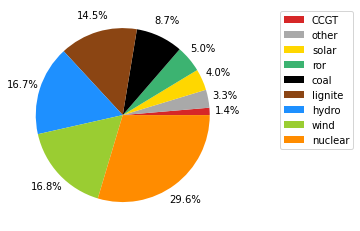

In [28]:
nz_gen_full = pd.read_csv('Output/nz_gen_8760.csv',parse_dates=True,index_col=0)
nz_storage_full = pd.read_csv('Output/nz_storage_8760.csv',parse_dates=True,index_col=0)

colors = {'CCGT':'tab:red','other':'darkgray','solar':'gold','ror':'mediumseagreen','coal':'black','lignite':'saddlebrown',
          'hydro':'dodgerblue','nuclear':'darkorange','wind':'yellowgreen'}

gen_frac = nz_gen_full.groupby(n.generators.carrier,axis=1).sum().sum()
gen_frac['other'] = gen_frac['Natural gas']+gen_frac['oil']+gen_frac['OCGT']+gen_frac['geothermal']+gen_frac['biomass']
gen_frac['wind'] = gen_frac['offwind-ac']+gen_frac['offwind-dc']+gen_frac['onwind']
gen_frac['hydro'] = nz_storage_full[nz_storage_full.columns[nz_storage_full.columns.str.contains('hydro')]].sum().sum()
gen_frac.drop(['Natural gas','oil','OCGT','geothermal','biomass','offwind-ac','offwind-dc','onwind'],inplace=True)

plt.pie(gen_frac.sort_values(),labels=gen_frac.sort_values().index,
        colors=[colors[i] for i in gen_frac.sort_values().index],
        autopct='%1.1f%%',pctdistance=1.2,labeldistance=None)
plt.legend(bbox_to_anchor=(1.2,1.0))

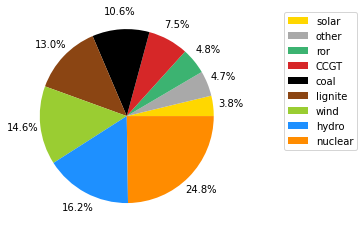

In [29]:
n4_storage_full = pd.read_csv('Output/n4_storage_8760.csv',parse_dates=True,index_col=0)

colors = {'CCGT':'tab:red','other':'darkgray','solar':'gold','ror':'mediumseagreen','coal':'black','lignite':'saddlebrown',
          'hydro':'dodgerblue','nuclear':'darkorange','wind':'yellowgreen'}

gen4_frac = n4_gen_full.groupby(n.generators.carrier,axis=1).sum().sum()
gen4_frac['other'] = gen4_frac['Natural gas']+gen4_frac['oil']+gen4_frac['OCGT']+gen4_frac['geothermal']+gen4_frac['biomass']
gen4_frac['wind'] = gen4_frac['offwind-ac']+gen4_frac['offwind-dc']+gen4_frac['onwind']
gen4_frac['hydro'] = n4_storage_full[n4_storage_full.columns[n4_storage_full.columns.str.contains('hydro')]].sum().sum()
gen4_frac.drop(['Natural gas','oil','OCGT','geothermal','biomass','offwind-ac','offwind-dc','onwind'],inplace=True)

plt.pie(gen4_frac.sort_values(),labels=gen4_frac.sort_values().index,
        colors=[colors[i] for i in gen4_frac.sort_values().index],
        autopct='%1.1f%%',pctdistance=1.2,labeldistance=None)
plt.legend(bbox_to_anchor=(1.2,1.0))

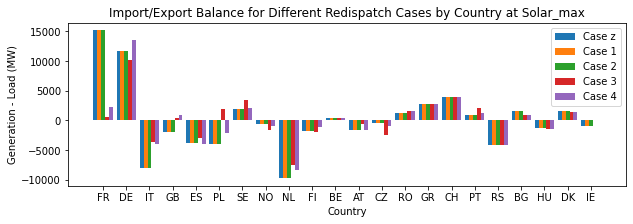

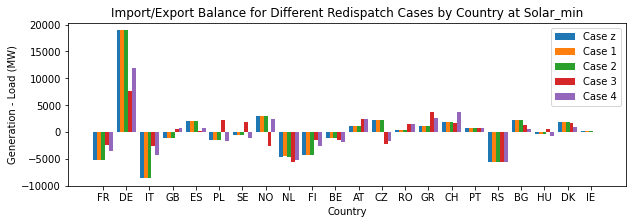

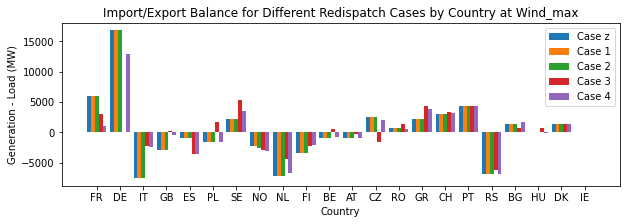

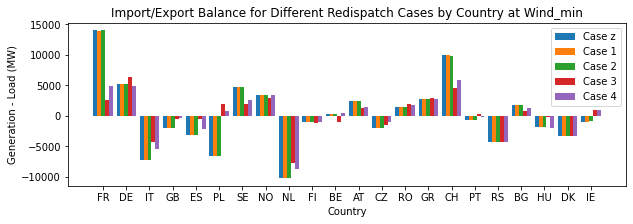

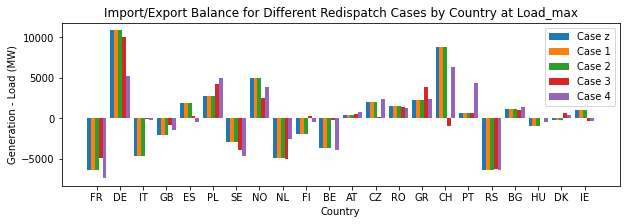

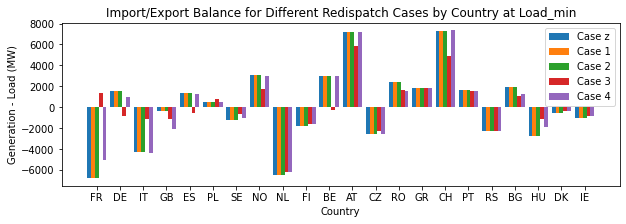

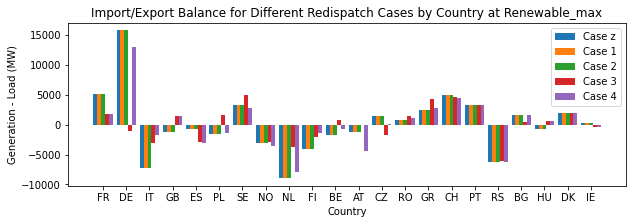

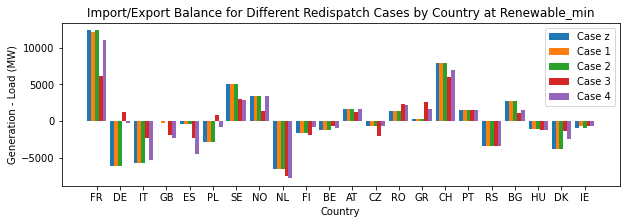

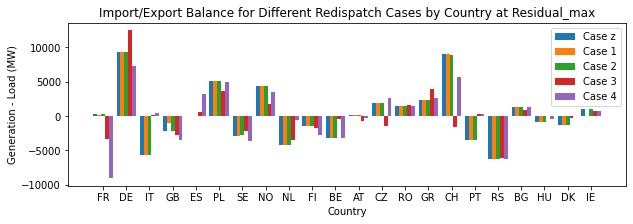

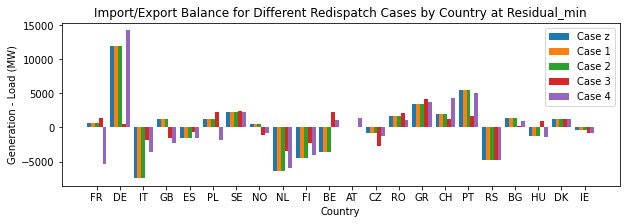

In [30]:
Country_Load = n.loads_t.p_set.iloc[Indices].groupby(n.buses.country,axis=1).sum()
Country_Gen = {}
Country_Gen['nz'] = Generation['nz'].groupby(n.generators.country,axis=1).sum().add(Storage['nz'].groupby(n.storage_units.country,axis=1).sum(),fill_value=0)
Country_Gen['n1'] = Generation['n1'].groupby(n.generators.country,axis=1).sum().add(Storage['n1'].groupby(n.storage_units.country,axis=1).sum(),fill_value=0)
Country_Gen['n2'] = Generation['n2'].groupby(n.generators.country,axis=1).sum().add(Storage['n2'].groupby(n.storage_units.country,axis=1).sum(),fill_value=0)
Country_Gen['n3'] = Generation['n3'].groupby(n.generators.country,axis=1).sum().add(Storage['n3'].groupby(n.storage_units.country,axis=1).sum(),fill_value=0)
Country_Gen['n4'] = Generation['n4'].groupby(n.generators.country,axis=1).sum().add(Storage['n4'].groupby(n.storage_units.country,axis=1).sum(),fill_value=0)


for j in np.arange(10):
    plt.figure(figsize=(10, 3))
    loc = 0
    for i in networks:
        xvals = np.arange(len(Top_22)) + (1/6*loc - 1/3)
        Data = Country_Gen[i].iloc[j]-Country_Load.iloc[j]
        plt.bar(xvals,Data[Top_22],label='Case '+str(i[-1:]),width=1/6)
        loc += 1
    plt.xticks(np.arange(len(Top_22)),Top_22)
    plt.legend()      
    plt.ylabel('Generation - Load (MW)')
    plt.xlabel('Country')
    plt.title('Import/Export Balance for Different Redispatch Cases by Country at ' + Index_labels[j])

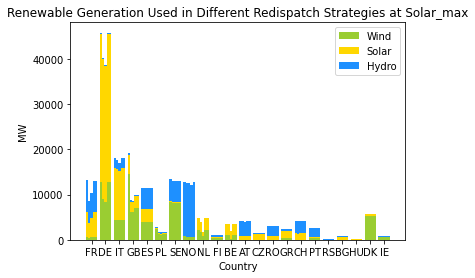

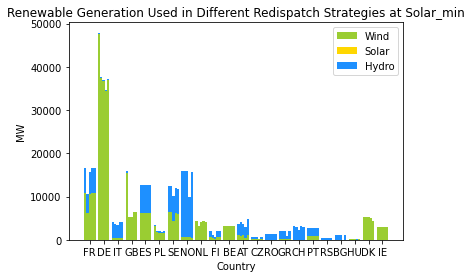

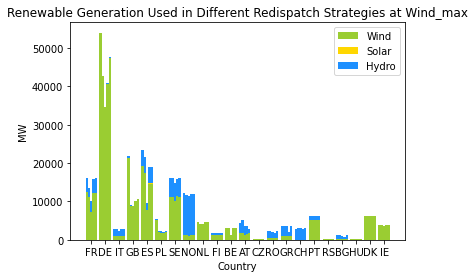

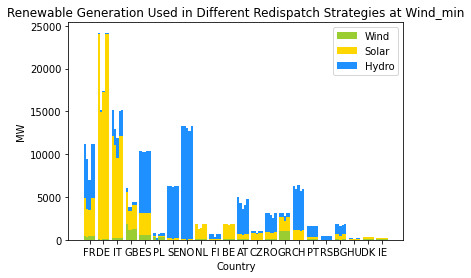

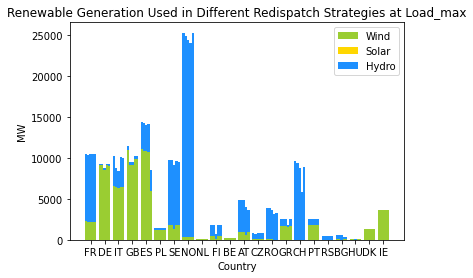

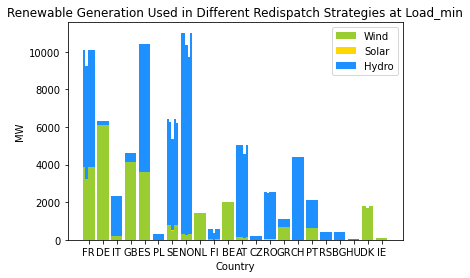

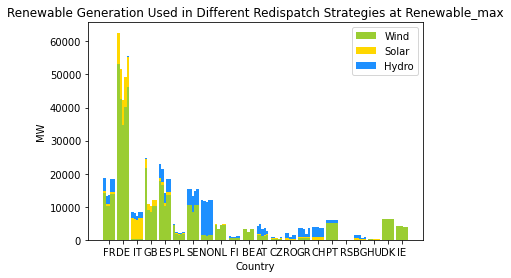

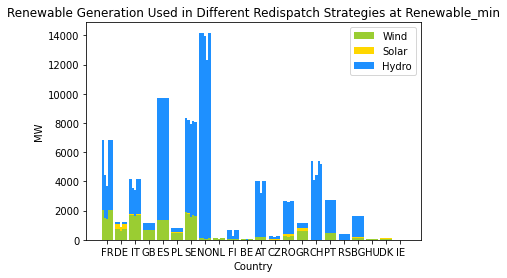

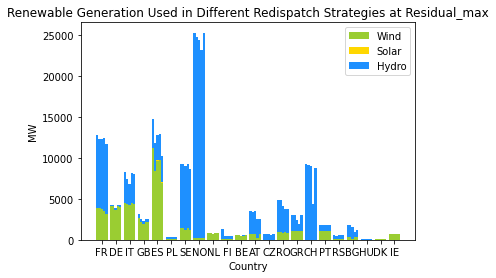

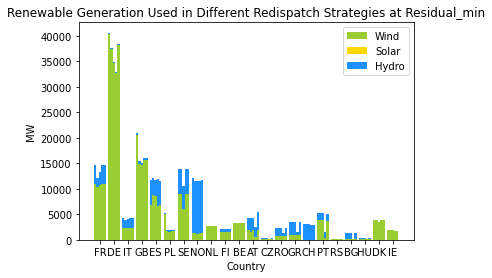

In [31]:
Colors = ['yellowgreen','gold','dodgerblue']
Renewables = ['wind','solar','hydro']
Ren_Gens = [wind_gens,solar_gens,hydro_gens]
Hydro_Countries = list(set(n.storage_units.country.unique()) & set(Top_22))
Hydro_Countries = Top_22[[(i in Hydro_Countries) for i in Top_22]]
legend_elements = [Patch(facecolor='yellowgreen',label='Wind'),
                   Patch(facecolor='gold',label='Solar'),
                   Patch(facecolor='dodgerblue',label='Hydro')]

for j in np.arange(10):
    plt.figure()
    for k in np.arange(3):
        loc = 0
        for i in networks:
            xvals = np.arange(len(Top_22)) + (1/6*loc - 1/3)
            if Renewables[k] == 'hydro':
                plt.bar(xvals[[(i in Hydro_Countries) for i in Top_22]],Storage[i][Ren_Gens[k]].groupby(n.storage_units.loc[Ren_Gens[k],'country'],axis=1).sum().iloc[j].loc[Hydro_Countries],
                        label=Renewables[k],color=Colors[k],width=1/6,
                        bottom=Generation[i][Ren_Gens[0]].groupby(n.generators.loc[Ren_Gens[0],'country'],axis=1).sum().iloc[j].loc[Hydro_Countries]+Generation[i][Ren_Gens[1]].groupby(n.generators.loc[Ren_Gens[1],'country'],axis=1).sum().iloc[j].loc[Hydro_Countries])
            elif k == 0:
                plt.bar(xvals,Generation[i][Ren_Gens[k]].groupby(n.generators.loc[Ren_Gens[k],'country'],axis=1).sum().iloc[j].loc[Top_22],
                        label=Renewables[k],color=Colors[k],width=1/6)
            elif k == 1:
                plt.bar(xvals,Generation[i][Ren_Gens[k]].groupby(n.generators.loc[Ren_Gens[k],'country'],axis=1).sum().iloc[j].loc[Top_22],
                        label=Renewables[k],color=Colors[k],width=1/6,
                        bottom=Generation[i][Ren_Gens[0]].groupby(n.generators.loc[Ren_Gens[0],'country'],axis=1).sum().iloc[j].loc[Top_22])                
            loc += 1
    plt.xticks(np.arange(len(Top_22)),Top_22)
    plt.legend(handles=legend_elements)      
    plt.ylabel('MW')
    plt.xlabel('Country')    
    plt.title('Renewable Generation Used in Different Redispatch Strategies at ' + Index_labels[j])

## Renewable Distributions

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
"""Onshore Wind"""

Wind_cf = n.generators_t.p_max_pu.loc[:,n.generators_t.p_max_pu.columns.str.contains('onwind')].mean()
Wind_cf.index = Wind_cf.index.str.split().str[0]

Wind_inst = n.generators.loc[n.generators.index.str.contains('onwind')].p_nom
Wind_inst.index = Wind_inst.index.str.split().str[0]
Wind_inst[Wind_inst>1500] = 1500

bus_s = pd.Series(index=Wind_inst.index,data=(Wind_inst > 5)*0.05).add(pd.Series(index=n.buses.index,data=0),fill_value=0)

plt.figure(0)
n.plot(bus_colors=Wind_cf,line_widths=1,link_widths=1,bus_sizes=bus_s,bus_cmap='RdYlBu')
plt.figure(1)
n.plot(bus_colors=Wind_inst,line_widths=1,link_widths=1,bus_sizes=bus_s,bus_cmap='plasma')


In [ ]:
"""Offshore Wind"""

Wind_off_cf =n.generators_t.p_max_pu.loc[:,n.generators_t.p_max_pu.columns.str.contains('offwind')].mean()
Wind_off_cf.index = Wind_off_cf.index.str.split().str[0]
Wind_off_cf = Wind_off_cf.groupby(level=0).sum()

Wind_off_inst = n.generators.loc[n.generators.index.str.contains('offwind')].p_nom
Wind_off_inst.index = Wind_off_inst.index.str.split().str[0]
Wind_off_inst = Wind_off_inst.groupby(level=0).sum()

bus_s = pd.Series(index=Wind_off_inst.index,data=(Wind_off_inst > 1)*0.1).add(pd.Series(index=n.buses.index,data=0),fill_value=0)

plt.figure(0)
n.plot(bus_colors=Wind_off_cf,line_widths=1,link_widths=1,bus_sizes=bus_s,bus_cmap='RdYlBu')
plt.figure(1)
n.plot(bus_colors=Wind_off_inst,line_widths=1,link_widths=1,bus_sizes=bus_s,bus_cmap='plasma')


In [ ]:
"""Solar"""

Solar_cf =n.generators_t.p_max_pu.loc[:,n.generators_t.p_max_pu.columns.str.contains('solar')].mean()
Solar_cf.index = Solar_cf.index.str.split().str[0]

Solar_inst = n.generators['p_nom'].loc[n.generators.index.str.contains('solar')]
Solar_inst.index = Solar_inst.index.str.split().str[0]

bus_s = pd.Series(index=Solar_inst.index,data=(Solar_inst > 5)*0.05).add(pd.Series(index=n.buses.index,data=0),fill_value=0)

plt.figure(0)
n.plot(bus_colors=Solar_cf,line_widths=1,link_widths=1,bus_sizes=bus_s,bus_cmap='plasma')
plt.figure(1)
n.plot(bus_colors=Solar_inst,line_widths=1,link_widths=1,bus_sizes=bus_s,bus_cmap='plasma')


In [ ]:
# This code plots a colorbar without a plot. Useful for the network plots. 

a = np.array([[0,Wind_inst.max()]]) # adjust this line to change colorbar range
plt.figure(figsize=(1,8))
img = plt.imshow(a, cmap="plasma")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.2, 0.8]) #switch third and fourth numbers for horizontal/vertical colorbar
plt.colorbar(orientation='vertical',cax=cax)

In [ ]:
storage = pd.read_csv('Output/n_Storage.csv',parse_dates=True,index_col=0)
storage25 = storage.std().sort_values().iloc[-25:].index
colors = {'NO':'tab:red','SE':'royalblue','CH':'gold','ES':'orange','SK':'yellowgreen','HR':'rebeccapurple','RO':'pink'}
legend_elements = [Patch(facecolor='tab:red',label='NO'),
                   Patch(facecolor='royalblue',label='SE'),
                   Patch(facecolor='gold',label='CH'),
                   Patch(facecolor='orange',label='ES'),
                   Patch(facecolor='yellowgreen',label='SK'),
                   Patch(facecolor='rebeccapurple',label='HR'),
                   Patch(facecolor='pink',label='RO')]

for i in storage25:
    plt.plot(storage[i],color=colors[n.buses.country.loc[i[:4]]])
    
plt.legend(handles=legend_elements,bbox_to_anchor=(1.2,1.0))  
plt.xlabel('Month')
plt.xticks(Line_Overload.index[360::732],[month_abbr[i] for i in np.arange(1,13)])
plt.ylabel('Storage State of Charge (MWh)')